In [102]:
import numpy as np
from mnist.loader import MNIST
import matplotlib.pyplot as plt
import glob
import os
import h5py
import librosa
import umap

from tqdm import tqdm
from pathlib import Path
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='poster')

In [211]:
#total 8000 tracks
def load_batches(root_path, sample_rate, batch_size):
    file_paths=[]
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.endswith('.mp3'):
                file_paths.append(os.path.join(root, file))
                
    np.random.seed(88)
    np.random.shuffle(file_paths)
    batch_index = 0
    
    for j in range(0, len(file_paths)//batch_size):
        audio=[]
        successful=[]

        for i in tqdm(range(batch_size*batch_index, batch_size*(batch_index+1)), 
                      desc=f"Batch {batch_index+1}/{int(len(file_paths)/batch_size)}"):
            flag = True
            try: 
                temp, _ =librosa.load(file_paths[i], sr=sample_rate)#, res_type='kaiser_fast')
                temp = librosa.util.normalize(temp)
                audio.append(temp)
            except Exception as e: 
                #print(f"error loading {file_paths[i]}: {str(e)}")
                #failed.append(file_paths[i])
                flag = False
                continue
            if flag: 
                successful.append(file_paths[i])
        yield audio, successful
        batch_index+=1
        del audio, successful


In [212]:
sample_rate = 5512
batch_size = 1000
big_data = load_batches('./fma_small', sample_rate, batch_size) #generator function
batches=[]
pathches=[]
small_data, file_paths = next(big_data)
batches.append(small_data)
pathches.append(file_paths)



Batch 1/8:  55%|█████▍    | 545/1000 [00:22<00:16, 27.60it/s][src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 63168.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/var/folders/v7/96pnb7v52cn4swxgq3j09dbm0000gq/T/ipykernel_86791/36254514.py:20: UserWarning: PySoundFile failed. Trying audioread instead.
  temp, _ =librosa.load(file_paths[i], sr=sample_rate)#, res_type='kaiser_fast')
/Users/user/Desktop/coding comps/transition/venv/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Batch 1/8: 100%|██████████| 1000/1000 [00:41<00:00, 24.01i

investigation.
https://stackoverflow.com/questions/65160046/librosa-does-not-normalize-wave-file-between-1-1

In [213]:
print(len(batches[0])) #first batch is 100 clips
print(len(batches[0][0])) #each clip is 30sec*5512 samples
print(batches[0][0]) #each sample 
print(np.mean(batches[0][0]))
print(np.std(batches[0][0]))

1000
165231
[ 1.2815298e-08 -3.2042287e-09  2.7270000e-08 ... -5.2540261e-02
 -4.7596648e-02 -1.3195980e-02]
-0.00016965589
0.095650725


STANDARDIZE INSTEAD OF NORMALIZING

In [214]:
def into_freqs(audio, sample_rate):
    mel_spec=librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    mel_db=librosa.power_to_db(mel_spec, ref=np.max) #scale to 1.0? perhaps??
    #librosa.display.specshow(mel_db, fmax=None, sr=sample_rate, x_axis='time', y_axis='mel')
    #plt.colorbar(format='%+2.0f dB')
    mel_normalized=2 * (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min()) - 1
    flattened = mel_normalized.flatten()
    return flattened

filtering out that one clip that's not the right length

In [215]:
batches_mels=[]
temp = []
for clip in tqdm(batches[0], desc='into freqs processing'):
   temp.append(into_freqs(clip, sample_rate))
batches_mels.append(temp)

#print(np.unique([len(i) for i in batches_mels[0]]))
lengths = [len(i) for i in batches_mels[0]]
most_common_length = max(set(lengths), key=lengths.count)
filtered_mels = [mel for mel in batches_mels[0] if len(mel) == most_common_length]
filtered_paths = [path for mel, path in zip(batches_mels[0], pathches[0]) if len(mel) == most_common_length]

print(len(pathches[0]))
batches_mels[0] = filtered_mels
pathches[0] = filtered_paths

into freqs processing: 100%|██████████| 1000/1000 [00:06<00:00, 144.71it/s]

1000


In [217]:
print(len(filtered_mels))
print(len(pathches[0]))

999
999


In [218]:
%%time
print(batches_mels[0])
print(len(batches_mels[0][0]))
unsup_embedding = umap.UMAP(n_neighbors=5).fit_transform(batches_mels[0])

[array([ 0.35873055,  0.3892889 ,  0.33042383, ..., -0.83553594,
       -0.6895673 , -0.6227739 ], shape=(41344,), dtype=float32), array([-0.24196756, -0.23116148, -0.27696097, ..., -1.        ,
       -1.        , -0.90893173], shape=(41344,), dtype=float32), array([-0.08817875, -0.104967  , -0.03751338, ..., -0.93878114,
       -1.        , -0.57435286], shape=(41344,), dtype=float32), array([-0.04838943,  0.06763387,  0.13440931, ..., -1.        ,
       -1.        , -0.59278333], shape=(41344,), dtype=float32), array([-0.22430027, -0.03980047,  0.03025222, ..., -0.7692181 ,
       -0.6225319 , -0.28912795], shape=(41344,), dtype=float32), array([-0.2713381 , -0.301376  , -0.34542847, ..., -1.        ,
       -1.        , -0.8338997 ], shape=(41344,), dtype=float32), array([-0.1192652 , -0.02949333, -0.15138942, ..., -0.73280907,
       -0.721598  , -0.5411455 ], shape=(41344,), dtype=float32), array([-0.13982898, -0.15128642,  0.08947635, ..., -0.56441945,
       -0.58259904, -0.40

/Users/user/Desktop/coding comps/transition/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 4.76 s, sys: 398 ms, total: 5.16 s
Wall time: 5.41 s


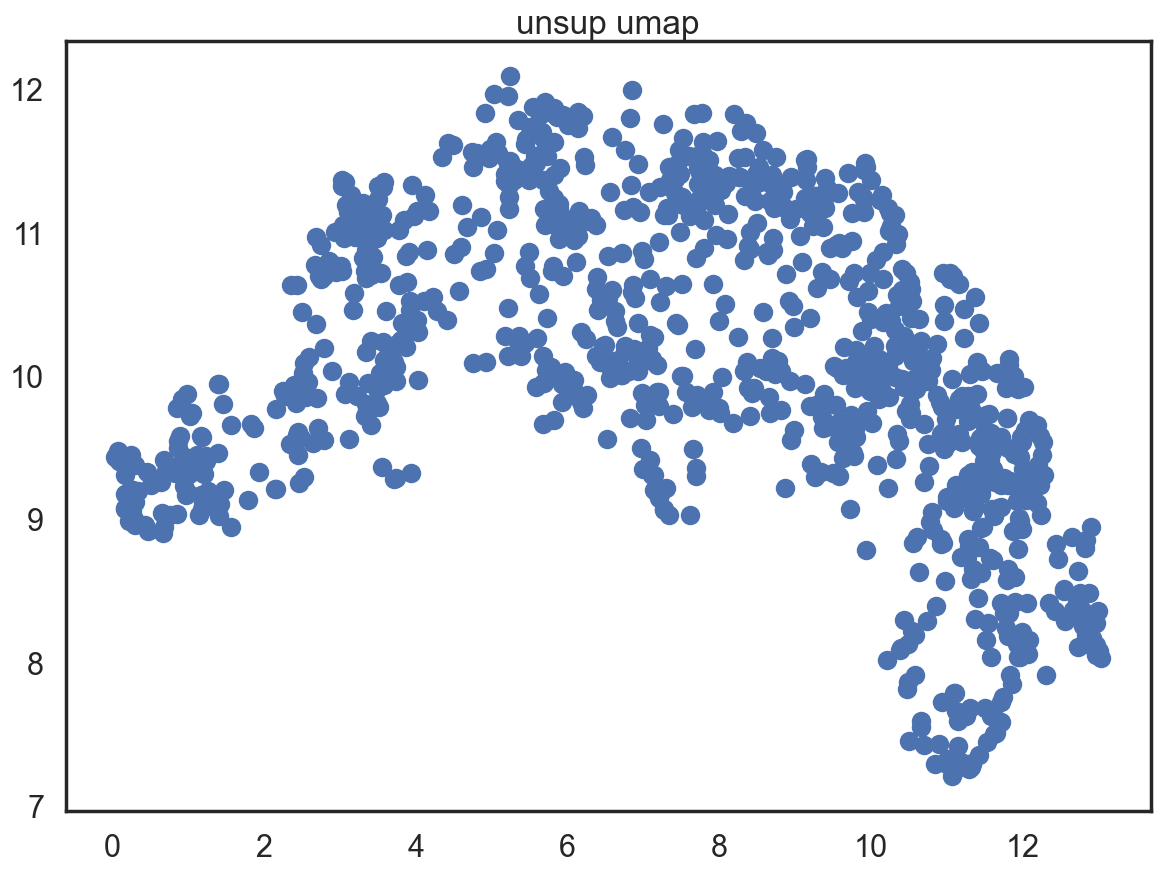

In [219]:
plt.figure(figsize=(14, 10))
plt.scatter(unsup_embedding[:,0], unsup_embedding[:, 1])
plt.title('unsup umap')
plt.show()

more interactive plot

In [224]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd


# Create a DataFrame with the UMAP coordinates and file paths
df = pd.DataFrame({
    'UMAP1': unsup_embedding[:, 0],
    'UMAP2': unsup_embedding[:, 1],
    'File Path': pathches[0]  # Make sure this is the list of file paths for your filtered data
})

# Create interactive scatter plot
fig = px.scatter(df, 
                 x='UMAP1', 
                 y='UMAP2',
                 hover_data=['File Path'],
                 title='UMAP Embedding of Audio Spectrograms')

# Add hover template to show file path
fig.update_traces(
    hovertemplate="<br>".join([
        "File: %{customdata[0]}",
        "UMAP1: %{x:.2f}",
        "UMAP2: %{y:.2f}",
    ])
)

fig.show()

In [235]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
import os
import flask
import librosa

good_files = []
for f in file_paths:
    try:
        y, sr = librosa.load(f, sr=sample_rate)
        good_files.append(f)  # Only keep files that load successfully
    except Exception as e:
        print(f"Skipping {f}: {e}")

# Set up your DataFrame
def get_relative_audio_path(full_path):
    # Get the part after 'fma_small/' in the full path
    idx = full_path.find('fma_small/')
    if idx >= 0:
        return full_path[idx + len('fma_small/'):]
    else:
        # fallback: just the filename
        return os.path.basename(full_path)

df['audio_url'] = df['File Path'].apply(lambda x: '/audio/' + get_relative_audio_path(x))


app = dash.Dash(__name__)
AUDIO_DIR = os.path.abspath('fma_small')

# Define the Flask route *before* running the app
@app.server.route('/audio/<path:filename>')
def serve_audio(filename):
    # Now 'filename' will be something like '096/096729.mp3'
    if '..' in filename or filename.startswith('/'):
        flask.abort(404)
    return flask.send_from_directory(AUDIO_DIR, filename)


# Now define your plot/figure
fig = px.scatter(df, x="UMAP1", y="UMAP2", hover_data=["File Path"], custom_data=['audio_url'])

app.layout = html.Div([
    dcc.Graph(id="scatter", figure=fig),
    html.Audio(id='audio-player', controls=True, src='')
])

@app.callback(
    Output('audio-player', 'src'),
    Input('scatter', 'clickData')
)
def update_audio(clickData):
    if clickData and "points" in clickData:
        # make sure the customdata field is present and correct
        return clickData["points"][0]["customdata"][0]
    return ''

if __name__ == "__main__":
    app.run(debug=True)


[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
